In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer

import plotly.express as px
import plotly.graph_objects as go

import os
import re 
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

sns.set()

C:\Users\dinar\AppData\Local\Temp\ipykernel_2868\765240082.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def show_plot(df, pred='preds'):
    agg_data = df.copy()
    agg_data.pricing_date = pd.to_datetime(agg_data.pricing_date)
    agg_data.forecast_date = agg_data.forecast_date.astype(str)

    agg_data = agg_data.set_index('pricing_date')

    df = agg_data.copy()
    df = df.sort_index(ascending=True)

    fig = px.line(df, x=df.index, y=pred, color='forecast_date', markers=True, height=600, width=1200)
    fig.update_traces(opacity=0.5, line=dict(width=2, ))

    df = agg_data.copy()
    df = df.sort_index(ascending=True)

    x = df.index
    y = df['target']
    name = 'target'
    fig.add_trace(
        go.Scatter(x=x, y=y, name=name, mode='lines+markers', opacity=0.5, marker=dict(color='darkgray', size=10),
                   line=dict(width=18, color='gray')))  # ,shape = 'hv'
    fig.show()
    

def show_results(results, save_path):
    thresh = 0.2

    results['nth_day'] = results.groupby('forecast_date')['preds'].cumcount()
    results['preds_diff'] = results.groupby('forecast_date')['preds'].diff()
    results['traget_diff'] = results.groupby('forecast_date')['target'].diff()
    results['preds_diff_cum'] = results.groupby('forecast_date')['preds_diff'].cumsum()
    results['traget_diff_cum'] = results.groupby('forecast_date')['traget_diff'].cumsum()
    results['preds_direct'] = results['preds_diff'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    results['traget_direct'] = results['traget_diff'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    results['preds_direct_cum'] = results['preds_diff_cum'].apply(
        lambda x: 1 if x > thresh else (-1 if x < -thresh else 0))
    results['traget_direct_cum'] = results['traget_diff_cum'].apply(
        lambda x: 1 if x > thresh else (-1 if x < -thresh else 0))
    results['pnl_stra_daily_direct'] = results['preds_direct'] * results['traget_diff']
    results['pnl_stra_cum_direct'] = results['preds_direct_cum'] * results['traget_diff_cum']

    fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
    results.pivot_table(index='pricing_date', values='pnl_stra_cum_direct', aggfunc=sum).cumsum().plot(ax=ax[0],
                                                                                                       title='pnl_stra_cum_direct')
    results.pivot_table(index='pricing_date', values='pnl_stra_daily_direct', aggfunc=sum).cumsum().plot(ax=ax[1],
                                                                                                         title='pnl_stra_daily_direct')
    fig.show()

In [3]:
def iterate(data, idx, step=100, low=False):
    # change step size if we have smaller input data
    step = 50 if low else 100

    # select starting point depending on the size of the input data
    start = idx * step if idx > 0 else 0

    # select ending point (if smaller, 300 days rolling window. Otherwise, 600)
    if low:
        end = 300 + step * idx
    else:
        end = 600 + step * idx

    train, val = data.iloc[start: start + end - 30, :], data.iloc[start + end - 30: start + end, :]
    return train, val


def custom_pnl_10(y_pred, y_true):
    nth = 10

    thresh = 0.2
    try:
        diff = y_pred[nth - 1] - y_pred[0]
    except IndexError:
        diff = y_pred[-1] - y_pred[0]

    direction = 1 if diff > thresh else (-1 if diff < thresh else 0)
    pnl = diff * direction

    return 'pnl', pnl



In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

class TargetFeature:
    def __init__(self, results_path, data, test_start, test_end, target='F380 M2/M3',
                 features=None, **kwargs):
        self.results_path = results_path

        self.data = data
        self.test_start = test_start
        self.test_end = test_end
        self.target = target
        self.features = features

        # define pd.DataFrame to store resulting df
        self.target_and_feature = None

        # define scaler
        self.scaler = MinMaxScaler()

        # define a starting message for log
        self.message = 'Task 2 [TargetFeature]:\n\t'

    def __call__(self, *args, **kwargs):
        self._setup()

    def _setup(self):
        # self.log(self.log_path, f'{self.message}Internal setup for target and feature columns...')
        target = self.data[self.target]
        target.interpolate(inplace=True)
        target.dropna(inplace=True)
        
        self.target_and_feature = pd.DataFrame(index=self.data.index)
        self.target_and_feature['actual_target'] = target
        self.target_and_feature['predicted_target'] = target
        
        if self.features is not None:            
            decompose = seasonal_decompose(target, model='additive', period=4)
            
            for feature in self.features:
                if feature in ['rolling', 'all']:
                    rolling = self.data[self.target].rolling(5).mean()
                    self.target_and_feature['actual_rolling'] = rolling[:self.test_end]
                    self.target_and_feature['predicted_rolling'] = rolling[:self.test_start]
                if feature in ['seasonality', 'all']:
                    self.target_and_feature['actual_seasonality'] = decompose.seasonal
                if feature in ['fft', 'all']:
                    fft_value = np.fft.fft(target)
                    self.target_and_feature['actual_fft_real'] = fft_value.real
                    self.target_and_feature['predicted_fft_real'] = self.target_and_feature['actual_fft_real'][:self.test_start]
                    self.target_and_feature['actual_fft_imag'] = fft_value.imag
                    self.target_and_feature['predicted_fft_imag'] = self.target_and_feature['actual_fft_imag'][:self.test_start]
                if feature in ['diff', 'all']:
                    self.target_and_feature['actual_diff'] = target.diff()
                    self.target_and_feature['predicted_diff'] = self.target_and_feature['actual_diff'][:self.test_start]
                if feature in ['seasonal_diff', 'all']:
                    self.target_and_feature['actual_seasonal_diff'] = decompose.seasonal.diff()
                if feature in ['ewm', 'all']:
                    self.target_and_feature['actual_ewm'] = target.ewm(span=30, adjust=True).mean()
                    self.target_and_feature['predicted_ewm'] = self.target_and_feature['actual_ewm'][:self.test_start]
            
            # self.target_and_feature.dropna(inplace=True)

            # fit a scaler
            columns = [x for x in self.target_and_feature if 'predicted' not in x and 'target' not in x]
            self.scaler.fit(self.target_and_feature[columns])


    def get_target_feature(self, end_date, start_date=None, include_past=False):
        # return all values until specified date
        if include_past:
            if start_date is not None:
                # self.log(self.log_path, f'Returning dates from {start_date} to {end_date}.')
                return self.target_and_feature.loc[start_date:end_date, :]
            # self.log(self.log_path, f'Returning all dates until {end_date}')
            return self.target_and_feature.loc[:end_date, :]

        # return one-day results
        try:
            entry = pd.DataFrame(self.target_and_feature.loc[end_date, :]).T
        except KeyError:
            # self.log(self.log_path, f'{self.message}Date {end_date} does not exist!', CRITICAL)
            raise KeyError(f'{self.message}Date {end_date} does not exist!')
        else:
            # self.log(self.log_path, f'Returned one-day instance for {end_date}.')
            return entry

    def set_target_feature(self, date, column, value):
        fmt = '%Y-%m-%d'

        # raise error if the supplemented date is less than the test start
        # if datetime.strptime(self.test_start, fmt) < datetime.strptime(date, fmt):
        #     message = f'Illegal date substitution {date}, expected to see dates between {self.test_start} to {date}.'
        #     self.log(self.log_path, self.message + message, CRITICAL)
        #     raise Exception(message)
        
        # with open('track.txt', 'a') as fout:
        #     fout.writelines(f'{date} - {column}: {value}\n')

        # get previous value
        previous = self.target_and_feature.loc[date, column]

        # log information
        # self.log(self.log_path, f'{self.message}Setting new value for {column}. Old: {previous}, new: {value}')

        # set new value
        self.target_and_feature.loc[date, column] = value

        # save current state
        # self.target_and_feature.reset_index(inplace=True)
        self.target_and_feature.to_csv(f'{self.results_path}/complete_target_feature_df.csv', index=True)
        # self.log(self.log_path, f'{self.message}Saving intermediate results in {self.results_path} CSV file.')


In [63]:
def train_model(data, test_start, test_end=None, target_col='F380 M2/M3', model_suffix='full', columns=None, final_refit=True, path=None, 
                use_features=False, n_estimators=1500, target_features=None, feat_importance='total_gain'):
    if columns is None and model_suffix == 'full':
        columns = [x for x in data.columns if x != target_col]
    elif columns is None and model_suffix != 'full':
        raise ValueError('Cannot train a subset of columns without specifying them! Please pass the columns ')
    
    # set the model name
    today_date = str(datetime.now())[:10]
    
    data.interpolate('linear', inplace=True)
    data.dropna(inplace=True)
    
    # create a target feature class
    if target_features is None:
        target_feature = TargetFeature(path, data, test_start, test_end, features=None)
    else:
        target_features = [target_features] if isinstance(target_features, str) else target_features
        target_feature = TargetFeature(path, data, test_start, test_end, features=target_features)
    target_feature()
    
    # drop target column
    data.drop(columns=[target_col], inplace=True)
    
    if target_col in columns:
        columns = list(columns)
        columns.remove(target_col)
        
    if len(columns) > 1:
        data = data[columns]
    
    # split to train/test
    train = data[data.index < test_start]
    
    if test_end:
        test = data[(data.index >= test_start) & (data.index < test_end)]
    else:
        test = data[data.index < test_end]
        
    # initiate normalization 
    scaler = MinMaxScaler()
    scaler.fit(train)
    
    # normalize data
    train = pd.DataFrame(scaler.transform(train), index=train.index, columns=train.columns)
    test = pd.DataFrame(scaler.transform(test), index=test.index, columns=train.columns)
    
    # get names for target_feature columns
    rolling, target = 'actual_feature', 'actual_target'
    
    # set parameters
    params = {'process_type': 'default', 'refresh_leaf': True, 'min_child_weight': 7,
              'subsample': 1, 'colsample_bytree': 0.5, 'eta': 0.03}
    
    if use_features:
    
        all_target_cols = ['actual_rolling', 'actual_seasonality', 'actual_fft_real', 'actual_fft_imag', 'actual_diff', 'actual_seasonal_diff', 'actual_ewm']
        all_pred_target_cols = ['predicted_rolling', 'predicted_fft_real', 'predicted_fft_imag', 'predicted_diff', 'predicted_ewm']

        current_target_cols = [col for col in all_target_cols if any(target in col for target in target_features)] if target_features != ['all'] else all_target_cols
        current_pred_target_cols = [col for col in all_pred_target_cols if any(target in col for target in target_features)] if target_features != ['all'] else all_pred_target_cols
        
        model_name = f'experiments/models/model-{model_suffix}-cols={len(columns) + len(current_target_cols)}_use_fe={use_features}_feat-import={feat_importance}_targ_fe={"_".join(target_features)}.model'
    else:
        model_name = f'experiments/models/model-{model_suffix}-cols={len(columns)}_use_fe={use_features}_feat-import={feat_importance}_targ_fe=False.model'
    
    # start pretraining the model
    for idx in range(300):
        # get batches
        train_temp, valid_temp = iterate(train, idx, low=False)

        # break if there are fewer values
        if len(train_temp) < 200 or len(valid_temp) <= 5: break

        # get rolling and target columns
        if use_features:
            train_temp[[target_col] + current_target_cols] = \
                target_feature.get_target_feature(end_date=train_temp.index.max(), start_date=train_temp.index.min(),
                                                include_past=True)[[target] + current_target_cols].values
            valid_temp[[target_col] + current_target_cols] = \
                target_feature.get_target_feature(end_date=valid_temp.index.max(), start_date=valid_temp.index.min(),
                                                include_past=True)[[target] + current_target_cols].values

            train_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
            valid_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
            train_temp.dropna(inplace=True)
            valid_temp.dropna(inplace=True)
            
            y_train = train_temp[target_col]
            y_test = valid_temp[target_col]
            
            train_temp.drop(columns=target_col, inplace=True)
            valid_temp.drop(columns=target_col, inplace=True)

            # normalize rolling
            train_temp[current_target_cols] = target_feature.scaler.transform(train_temp[current_target_cols])
            valid_temp[current_target_cols] = target_feature.scaler.transform(valid_temp[current_target_cols])

        else:
            y_train = target_feature.get_target_feature(end_date=train_temp.index.max(), start_date=train_temp.index.min(),
                                                include_past=True)[target].values
            y_test = target_feature.get_target_feature(end_date=valid_temp.index.max(), start_date=valid_temp.index.min(),
                                                include_past=True)[target].values

        if idx == 0:
            model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist')
            model.fit(train_temp, y_train, eval_set=[(valid_temp, y_test)], early_stopping_rounds=15, verbose=False)
            
        else:
            model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist', xgb_model=model_name)
            model.load_model(model_name)
            model.fit(train_temp, y_train, eval_set=[(valid_temp, y_test)], early_stopping_rounds=15, verbose=False)

        model.save_model(model_name)

    # final refit
    full_train = train.copy()
    
    if use_features:
        full_train[[target_col] + current_target_cols] = target_feature.get_target_feature(end_date=train.index.max(),
                                                                                           include_past=True)[[target] + current_target_cols].values

    else:
        full_train[target_col] = target_feature.get_target_feature(end_date=train.index.max(), include_past=True)[target].values
        
    full_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    full_train.dropna(inplace=True)
    
    y_train = full_train[target_col]
    full_train.drop(columns=target_col, inplace=True)

    if use_features:
        # normalize data
        full_train[current_target_cols] = target_feature.scaler.transform(full_train[current_target_cols])
    
    model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist', xgb_model=model_name)
    model.load_model(model_name)
    model.fit(full_train, y_train, verbose=False)

    model.save_model(model_name)

    if use_features:
        return model, train, test, scaler, target_feature, current_target_cols, model_name
    
    return model, train, test, scaler, target_feature, model_name


def get_columns(columns_selection, model, feat_eng_thresh=30, feat_importance='total_gain'):
    if columns_selection == 'xgboost':
        scores = model.get_booster().get_score(importance_type=feat_importance)
        temp_df = pd.DataFrame({'columns': scores.keys(), 'values': scores.values()})
        return temp_df[temp_df['values'] >= feat_eng_thresh]['columns'].to_list()


def get_predictions(data, results_folder, test_start, test_end, columns_selection='xgboost', use_features=False, 
                    n_estimators=1500, target_features=None, use_fe=False, feat_eng_thresh=30, feat_importance='total_gain'):
    if use_fe:
        model, train, test, scaler, target_feature, model_name = train_model(data.copy(), test_start=test_start, test_end=test_end, 
                                                                 columns=data.columns, path=results_folder, 
                                                                 use_features=False, n_estimators=n_estimators, target_features=None,
                                                                 feat_importance='total_gain')

        columns = get_columns(columns_selection, model, feat_eng_thresh, feat_importance=feat_importance)
        columns = [x for x in columns if not x.startswith('rolling')]
        
        print('Removing temporary model:', model_name)
        os.remove(model_name)
    else:
        columns = data.drop(columns='F380 M2/M3').columns
    
    # refit the model with selected columns
    if use_features:
        model, train, test, scaler, target_feature, current_target_cols, model_name = train_model(data.copy(), test_start=test_start, test_end=test_end, 
                                                                                                model_suffix='partial', columns=columns, path=results_folder, 
                                                                                                use_features=use_features, n_estimators=n_estimators, 
                                                                                                target_features=target_features, feat_importance=feat_importance)
    else:
        model, train, test, scaler, target_feature, model_name = train_model(data.copy(), test_start=test_start, test_end=test_end, 
                                                                            model_suffix='partial', columns=columns, path=results_folder, 
                                                                            use_features=use_features, n_estimators=n_estimators, 
                                                                            target_features=target_features, feat_importance=feat_importance)
    
    print('============')
    print(f'Use target features: {use_features} [{target_features}]')
    print(f'Use feature engineering for column selection: {use_fe} [type={feat_importance} >= {feat_eng_thresh}]')
    print('Model is stored in:', model_name)
    print('Number of columns:', len(columns))
    print('Columns:', columns, end='\n============\n')
    
    window_size = 10
    results_df = pd.DataFrame(columns=['pricing_date', 'preds', 'target', 'forecast_date'])
    market_data = data.copy()
    
    t1_to_10_values = market_data[market_data.index >= test_start].iloc[0, -10:]

    for counter in range(len(test)):
        try:
            sliding_history = market_data[market_data.index >= test_start].iloc[counter: counter + window_size, :]
        except IndexError:
            pass
        else:
            # verify the length of the sliding history == window_size
            if len(sliding_history) < window_size:
                break

            # copy original data
            full_history = market_data.copy()

            # keep track of every 0th value to select all actual targets and then predictions afterward
            first_day, second_day = None, None
            
            t1_to_10_values = list(sliding_history.iloc[-1, -10:].values)

            for counter2 in range(window_size):
                try:
                    sliding_start_date = pd.DataFrame(sliding_history.iloc[counter2, :]).T.index.values[0]

                    if counter2 == 1:
                        second_day = sliding_start_date

                except IndexError:
                    pass
                else:                    
                    expanding_history = full_history[full_history.index <= sliding_start_date]

                    # get test value and convert to DMatrix
                    testx = pd.DataFrame(expanding_history.iloc[-1, :]).T
                    testx = testx[columns]
                    
                    print('Testx columns:', columns)
                    
                    if counter2 == 0:
                        t1_to_10_values = list(testx.iloc[0, -10:])
                        print('Original values at index 0 are not touched:', t1_to_10_values)
                    else:
                        print(f'Index at {counter2} is changed to: {t1_to_10_values}')
                    
                    # cols = [f't-{x}' for x in range(1, 10)]
                    # print('Columns to change:', testx.iloc[0, -10:].columns)
                    
                    testx.iloc[0, -10:] = t1_to_10_values

                    # normalize features
                    testx = pd.DataFrame(scaler.transform(testx), columns=testx.columns, index=testx.index)

                    # select current state of the target/feature dataframe
                    current_values = target_feature.get_target_feature(sliding_start_date, include_past=True)
                    
                    # select actual values for the first predictions
                    if counter2 == 0:
                        current_targets = current_values['actual_target']
                    else:
                        current_targets = current_values['actual_target'].copy()
                        current_targets.loc[second_day:sliding_start_date] = current_values['predicted_target'].loc[
                                                                             second_day:sliding_start_date]
                    if use_features:
                        decompose = seasonal_decompose(current_targets, model='additive', period=4)
                        fft_value = np.fft.fft(current_targets)
                        
                        features = pd.DataFrame(index=current_targets.index)
                        
                        for feature in current_target_cols:                            
                            if feature == 'actual_rolling':
                                method = current_targets.rolling(5).mean()
                            if feature == 'actual_ewm':
                                method = current_targets.ewm(span=30, adjust=True).mean()
                            if feature == 'actual_trend':
                                method = decompose.trend
                            if feature == 'actual_seasonality':
                                method = current_values['actual_seasonality']
                            if feature == 'actual_fft_imag':
                                method = fft_value.imag 
                            if feature == 'actual_fft_real':
                                method = fft_value.real
                            if feature == 'actual_diff':
                                method = current_targets.diff()
                            if feature == 'actual_seasonal_diff':
                                method = decompose.seasonal.diff()
                            
                            features[feature] = method
                        
                        try:
                            features = pd.DataFrame(target_feature.scaler.transform(features), index=features.index, columns=features.columns)
                            features = features.loc[:sliding_start_date]
                        except ValueError:
                            pass
                        
                        for col in features.columns:
                            testx[col] = features.loc[sliding_start_date, col]

                    # get predictions
                    prediction = model.predict(testx)
                    
                    # append to t-1 place
                    t1_to_10_values.insert(0, prediction)
                    t1_to_10_values.pop()
                    
                    # substitute values for the next iteration

                    # append new prediction to predicted target column
                    target_feature.set_target_feature(str(sliding_start_date)[:10], 'predicted_target', prediction)

                    if use_features:
                        inverse = target_feature.scaler.inverse_transform(testx[current_target_cols])
                        
                        for idx, feature in enumerate(current_target_cols):
                            target_feature.set_target_feature(str(sliding_start_date)[:10], feature, inverse[0][idx])

                    # record results
                    results_df = pd.concat([results_df, pd.DataFrame({
                        'pricing_date': testx.index,
                        'preds': prediction,
                        'target': current_values.loc[sliding_start_date, 'actual_target'],
                        'forecast_date': sliding_history.index.min()

                    })], ignore_index=True)
                print('\n=====\n')
               
                    
    results_df.to_csv(f'{results_folder}/results-for-{test_start}.csv')
    show_results(results_df, f'{results_folder}/daily_pnl-for-{test_start}.png')
    show_plot(results_df)

    return {'results_df': results_df, 'model': model, 'target_feature': target_feature, 
            'target_features': target_features, 'model_name': model_name, 'columns': columns,
            'scaler': scaler}

In [54]:
def target_manipulations(data, target):
    shifted = pd.DataFrame(columns=[f't{x}' for x in range(-1, -11, -1)], index=data.index)
    shifted = shifted[::-1]                           # reverse the dataframe
    
    reversed_data = data.reset_index()[::-1]          # reverse the original df
    
    for i, (idx, row) in enumerate(reversed_data[[target]].iterrows()):
        vals = []
        
        for ix in range(1, 11):
            try:
                ixs = idx - ix
                
                if ixs < 0:
                    vals.append(np.nan)
                else:
                    val = reversed_data.iloc[-ixs - 1][target]
                    vals.append(val)
                print('ix:', ix, 'idx:', idx, 'i:', i, 'ixs:', ixs)
            except IndexError:
                vals.append(np.nan)
            except ZeroDivisionError:
                vals.append(np.nan)
        
        shifted.iloc[i, :] = vals
    
    # reverse back, merge, and remove the first values
    shifted = shifted.reset_index()[::-1]
    shifted = shifted.merge(data[target], on='pricing_date')
    shifted = shifted.iloc[20:, :]
    shifted.drop(columns=target, inplace=True)
    
    # shifted = shifted[shifted.columns[::-1]]
    
    return shifted
    
    

def get_data(path, test_start, test_end, target='F380 M2/M3'):
    data = pd.read_csv(path)
    data.pricing_date = pd.to_datetime(data.pricing_date)
    data.set_index('pricing_date', inplace=True)
    data.interpolate('linear', inplace=True)
    
    # slice the dataset
    data = data[data.index < test_end]
    
    data['year_sin'] = np.sin(data.index.year / data.index.year.max() * 2 * np.pi)
    data['month_sin'] = np.sin(data.index.month / data.index.month.max() * 2 * np.pi)
    data['day_sin'] = np.sin(data.index.day / data.index.day.max() * 2 * np.pi)
    data['dow_sin'] = np.sin(data.index.dayofweek / data.index.dayofweek.max() * 2 * np.pi)


    data['year_num'] = data.index.year
    data['month_num'] = data.index.month
    data['day_num'] = data.index.day
    data['dow_num'] = data.index.dayofweek
    
    # get t-1, ..., t-10
    lags = target_manipulations(data, target)
    
    return data, lags
    

In [55]:
data, lags = get_data('../data/data_2024-02-02.csv', '2023-01-01', '2024-01-01')

ix: 1 idx: 1818 i: 0 ixs: 1817
ix: 2 idx: 1818 i: 0 ixs: 1816
ix: 3 idx: 1818 i: 0 ixs: 1815
ix: 4 idx: 1818 i: 0 ixs: 1814
ix: 5 idx: 1818 i: 0 ixs: 1813
ix: 6 idx: 1818 i: 0 ixs: 1812
ix: 7 idx: 1818 i: 0 ixs: 1811
ix: 8 idx: 1818 i: 0 ixs: 1810
ix: 9 idx: 1818 i: 0 ixs: 1809
ix: 10 idx: 1818 i: 0 ixs: 1808
ix: 1 idx: 1817 i: 1 ixs: 1816
ix: 2 idx: 1817 i: 1 ixs: 1815
ix: 3 idx: 1817 i: 1 ixs: 1814
ix: 4 idx: 1817 i: 1 ixs: 1813
ix: 5 idx: 1817 i: 1 ixs: 1812
ix: 6 idx: 1817 i: 1 ixs: 1811
ix: 7 idx: 1817 i: 1 ixs: 1810
ix: 8 idx: 1817 i: 1 ixs: 1809
ix: 9 idx: 1817 i: 1 ixs: 1808
ix: 10 idx: 1817 i: 1 ixs: 1807
ix: 1 idx: 1816 i: 2 ixs: 1815
ix: 2 idx: 1816 i: 2 ixs: 1814
ix: 3 idx: 1816 i: 2 ixs: 1813
ix: 4 idx: 1816 i: 2 ixs: 1812
ix: 5 idx: 1816 i: 2 ixs: 1811
ix: 6 idx: 1816 i: 2 ixs: 1810
ix: 7 idx: 1816 i: 2 ixs: 1809
ix: 8 idx: 1816 i: 2 ixs: 1808
ix: 9 idx: 1816 i: 2 ixs: 1807
ix: 10 idx: 1816 i: 2 ixs: 1806
ix: 1 idx: 1815 i: 3 ixs: 1814
ix: 2 idx: 1815 i: 3 ixs: 1813
ix: 3

In [56]:
data.merge(lags, on='pricing_date').iloc[:, -11:].tail(50)

dow_num    t-1    t-2    t-3    t-4    t-5    t-6    t-7    t-8    t-9  \
1749        0   4.75   5.25   5.25   4.55   4.75   3.75   4.75   4.75    4.0   
1750        1    4.0   4.75   5.25   5.25   4.55   4.75   3.75   4.75   4.75   
1751        2   3.75    4.0   4.75   5.25   5.25   4.55   4.75   3.75   4.75   
1752        3   1.75   3.75    4.0   4.75   5.25   5.25   4.55   4.75   3.75   
1753        4    2.0   1.75   3.75    4.0   4.75   5.25   5.25   4.55   4.75   
1754        0    1.5    2.0   1.75   3.75    4.0   4.75   5.25   5.25   4.55   
1755        1    0.0    1.5    2.0   1.75   3.75    4.0   4.75   5.25   5.25   
1756        2    1.0    0.0    1.5    2.0   1.75   3.75    4.0   4.75   5.25   
1757        3    1.0    1.0    0.0    1.5    2.0   1.75   3.75    4.0   4.75   
1758        4    2.5    1.0    1.0    0.0    1.5    2.0   1.75   3.75    4.0   
1759        0   3.25    2.5    1.0    1.0    0.0    1.5    2.0   1.75   3.75   
1760        1    2.8   3.25    2.5    1.0    1.0    0.0    1.5    2.0   1.75   
1761        2    2.5    2.8   3.25    2.5    1.0    1.0    0.0    1.5    2.0   
1762        3   3.75    2.5    2.8   3.25    2.5    1.0    1.0    0.0    1.5   
1763        4   3.75   3.75    2.5    2.8   3.25    2.5    1.0    1.0    0.0   
1764        0    4.0   3.75   3.75    2.5    2.8   3.25    2.5    1.0    1.0   
1765        1  3.525    4.0   3.75   3.75    2.5    2.8   3.25    2.5    1.0   
1766        2   3.05  3.525    4.0   3.75   3.75    2.5    2.8   3.25    2.5   
1767        3   3.75   3.05  3.525    4.0   3.75   3.75    2.5    2.8   3.25   
1768        4    5.0   3.75   3.05  3.525    4.0   3.75   3.75    2.5    2.8   
1769        0    4.5    5.0   3.75   3.05  3.525    4.0   3.75   3.75    2.5   
1770        1   4.25    4.5    5.0   3.75   3.05  3.525    4.0   3.75   3.75   
1771        2    3.5   4.25    4.5    5.0   3.75   3.05  3.525    4.0   3.75   
1772        3   4.25    3.5   4.25    4.5    5.0   3.75   3.05  3.525    4.0   
1773        4   4.25   4.25    3.5   4.25    4.5    5.0   3.75   3.05  3.525   
1774        0   4.95   4.25   4.25    3.5   4.25    4.5    5.0   3.75   3.05   
1775        1   4.95   4.95   4.25   4.25    3.5   4.25    4.5    5.0   3.75   
1776        2    5.0   4.95   4.95   4.25   4.25    3.5   4.25    4.5    5.0   
1777        3   6.25    5.0   4.95   4.95   4.25   4.25    3.5   4.25    4.5   
1778        4    5.5   6.25    5.0   4.95   4.95   4.25   4.25    3.5   4.25   
1779        0    2.5    5.5   6.25    5.0   4.95   4.95   4.25   4.25    3.5   
1780        1    2.5    2.5    5.5   6.25    5.0   4.95   4.95   4.25   4.25   
1781        2    2.5    2.5    2.5    5.5   6.25    5.0   4.95   4.95   4.25   
1782        3    2.0    2.5    2.5    2.5    5.5   6.25    5.0   4.95   4.95   
1783        4    1.5    2.0    2.5    2.5    2.5    5.5   6.25    5.0   4.95   
1784        0   1.75    1.5    2.0    2.5    2.5    2.5    5.5   6.25    5.0   
1785        1    2.5   1.75    1.5    2.0    2.5    2.5    2.5    5.5   6.25   
1786        2    2.3    2.5   1.75    1.5    2.0    2.5    2.5    2.5    5.5   
1787        3   2.25    2.3    2.5   1.75    1.5    2.0    2.5    2.5    2.5   
1788        4    2.5   2.25    2.3    2.5   1.75    1.5    2.0    2.5    2.5   
1789        0    2.0    2.5   2.25    2.3    2.5   1.75    1.5    2.0    2.5   
1790        1   2.75    2.0    2.5   2.25    2.3    2.5   1.75    1.5    2.0   
1791        2   2.75   2.75    2.0    2.5   2.25    2.3    2.5   1.75    1.5   
1792        3   2.75   2.75   2.75    2.0    2.5   2.25    2.3    2.5   1.75   
1793        4   2.85   2.75   2.75   2.75    2.0    2.5   2.25    2.3    2.5   
1794        0    3.5   2.85   2.75   2.75   2.75    2.0    2.5   2.25    2.3   
1795        1  3.225    3.5   2.85   2.75   2.75   2.75    2.0    2.5   2.25   
1796        2   2.95  3.225    3.5   2.85   2.75   2.75   2.75    2.0    2.5   
1797        3   3.15   2.95  3.225    3.5   2.85   2.75   2.75   2.75    2.0   
1798  

In [57]:
data = data.merge(lags, on='pricing_date')
data

pricing_date  ALVARI  ARAMCOSG  ARAMCOTF  ARCENERGY  BBEN      BPSG  \
0      2017-02-07     0.0       0.0       0.0        0.0   0.0  6.837607   
1      2017-02-08     0.0       0.0       0.0        0.0   0.0  6.536388   
2      2017-02-09     0.0       0.0       0.0        0.0   0.0  6.759142   
3      2017-02-10     0.0       0.0       0.0        0.0   0.0  6.778116   
4      2017-02-13     0.0       0.0       0.0        0.0   0.0  7.776573   
...           ...     ...       ...       ...        ...   ...       ...   
1794   2023-12-25     0.0       0.0       0.0        0.0   0.0  2.300491   
1795   2023-12-26     0.0       0.0       0.0        0.0   0.0  2.404817   
1796   2023-12-27     0.0       0.0       0.0        0.0   0.0  2.791667   
1797   2023-12-28     0.0       0.0       0.0        0.0   0.0  2.700562   
1798   2023-12-29     0.0       0.0       0.0        0.0   0.0  2.847652   

      BRIGHTOILSG  BUYER1  BUYER2  ...    t-1    t-2    t-3    t-4   t-5  \
0             0.0     0.0     0.0  ...   0.45    0.7  -0.45  -0.35 -0.75   
1             0.0     0.0     0.0  ...   0.25   0.45    0.7  -0.45 -0.35   
2             0.0     0.0     0.0  ...    0.4   0.25   0.45    0.7 -0.45   
3             0.0     0.0     0.0  ...    0.1    0.4   0.25   0.45   0.7   
4             0.0     0.0     0.0  ...   0.25    0.1    0.4   0.25  0.45   
...           ...     ...     ...  ...    ...    ...    ...    ...   ...   
1794          0.0     0.0     0.0  ...    3.5   2.85   2.75   2.75  2.75   
1795          0.0     0.0     0.0  ...  3.225    3.5   2.85   2.75  2.75   
1796          0.0     0.0     0.0  ...   2.95  3.225    3.5   2.85  2.75   
1797          0.0     0.0     0.0  ...   3.15   2.95  3.225    3.5  2.85   
1798          0.0     0.0     0.0  ...   3.45   3.15   2.95  3.225   3.5   

        t-6    t-7    t-8    t-9   t-10  
0    -0.275    0.2   0.15   0.15    0.8  
1     -0.75 -0.275    0.2   0.15   0.15  
2     -0.35  -0.75 -0.275    0.2   0.15  
3     -0.45  -0.35  -0.75 -0.275    0.2  
4       0.7  -0.45  -0.35  -0.75 -0.275  
...     ...    ...    ...    ...    ...  
1794    2.0    2.5   2.25    2.3    2.5  
1795   2.75    2.0    2.5   2.25    2.3  
1796   2.75   2.75    2.0    2.5   2.25  
1797   2.75   2.75   2.75    2.0    2.5  
1798   2.85   2.75   2.75   2.75    2.0  

[1799 rows x 86 columns]

In [58]:
data.set_index('pricing_date', inplace=True)
data

ALVARI  ARAMCOSG  ARAMCOTF  ARCENERGY  BBEN      BPSG  \
pricing_date                                                          
2017-02-07       0.0       0.0       0.0        0.0   0.0  6.837607   
2017-02-08       0.0       0.0       0.0        0.0   0.0  6.536388   
2017-02-09       0.0       0.0       0.0        0.0   0.0  6.759142   
2017-02-10       0.0       0.0       0.0        0.0   0.0  6.778116   
2017-02-13       0.0       0.0       0.0        0.0   0.0  7.776573   
...              ...       ...       ...        ...   ...       ...   
2023-12-25       0.0       0.0       0.0        0.0   0.0  2.300491   
2023-12-26       0.0       0.0       0.0        0.0   0.0  2.404817   
2023-12-27       0.0       0.0       0.0        0.0   0.0  2.791667   
2023-12-28       0.0       0.0       0.0        0.0   0.0  2.700562   
2023-12-29       0.0       0.0       0.0        0.0   0.0  2.847652   

              BRIGHTOILSG  BUYER1  BUYER2  CAOSG  ...    t-1    t-2    t-3  \
pricing_date                                      ...                        
2017-02-07            0.0     0.0     0.0    0.0  ...   0.45    0.7  -0.45   
2017-02-08            0.0     0.0     0.0    0.0  ...   0.25   0.45    0.7   
2017-02-09            0.0     0.0     0.0    0.0  ...    0.4   0.25   0.45   
2017-02-10            0.0     0.0     0.0    0.0  ...    0.1    0.4   0.25   
2017-02-13            0.0     0.0     0.0    0.0  ...   0.25    0.1    0.4   
...                   ...     ...     ...    ...  ...    ...    ...    ...   
2023-12-25            0.0     0.0     0.0    0.0  ...    3.5   2.85   2.75   
2023-12-26            0.0     0.0     0.0    0.0  ...  3.225    3.5   2.85   
2023-12-27            0.0     0.0     0.0    0.0  ...   2.95  3.225    3.5   
2023-12-28            0.0     0.0     0.0    0.0  ...   3.15   2.95  3.225   
2023-12-29            0.0     0.0     0.0    0.0  ...   3.45   3.15   2.95   

                t-4   t-5    t-6    t-7    t-8    t-9   t-10  
pricing_date                                                  
2017-02-07    -0.35 -0.75 -0.275    0.2   0.15   0.15    0.8  
2017-02-08    -0.45 -0.35  -0.75 -0.275    0.2   0.15   0.15  
2017-02-09      0.7 -0.45  -0.35  -0.75 -0.275    0.2   0.15  
2017-02-10     0.45   0.7  -0.45  -0.35  -0.75 -0.275    0.2  
2017-02-13     0.25  0.45    0.7  -0.45  -0.35  -0.75 -0.275  
...             ...   ...    ...    ...    ...    ...    ...  
2023-12-25     2.75  2.75    2.0    2.5   2.25    2.3    2.5  
2023-12-26     2.75  2.75   2.75    2.0    2.5   2.25    2.3  
2023-12-27     2.85  2.75   2.75   2.75    2.0    2.5   2.25  
2023-12-28      3.5  2.85   2.75   2.75   2.75    2.0    2.5  
2023-12-29    3.225   3.5   2.85   2.75   2.75   2.75    2.0  

[1799 rows x 85 columns]

In [59]:
data.iloc[:, -11:].to_csv('with_t_values.csv')

Use target features: False [None]
Use feature engineering for column selection: False [type=total_gain >= 30]
Model is stored in: experiments/models/model-partial-cols=84_use_fe=False_feat-import=total_gain_targ_fe=False.model
Number of columns: 84
Columns: Index(['ALVARI', 'ARAMCOSG', 'ARAMCOTF', 'ARCENERGY', 'BBEN', 'BPSG',
       'BRIGHTOILSG', 'BUYER1', 'BUYER2', 'CAOSG', 'CARGILLSG', 'CCMA',
       'CHEVRONSG', 'COASTAL', 'ENEOSSG', 'ENOC', 'FREEPTSG', 'GLENCORESG',
       'GPGLOBALSG', 'GULFSG', 'GUNVORSG', 'HL', 'IDEMITSU', 'ITGRES',
       'KAIROS', 'KOCHRI', 'LUKOIL', 'MACQUARIESG', 'MAERSKSG',
       'MERCURIARESOURCES', 'MERCURIASG', 'METS', 'MIPCO', 'P66SG', 'PETCO',
       'PETROCHINA', 'PETROSUMMIT', 'PTT', 'REPSOLSG', 'REXCOMM', 'RGES',
       'SELLER1', 'SIETCO', 'SINOHKPET', 'SINOPECFO', 'SINOPECHKSG', 'SKEISG',
       'SOCAR', 'SUMMITENERGY', 'TOTALSG', 'TRAFI', 'UNIPECSG', 'VITOLSG',
       'WANXIANG', 'ZENROCK', '_rgp_01_sz_3', '_rgp_02_sz_3', '_rgp_03_sz_3',
      

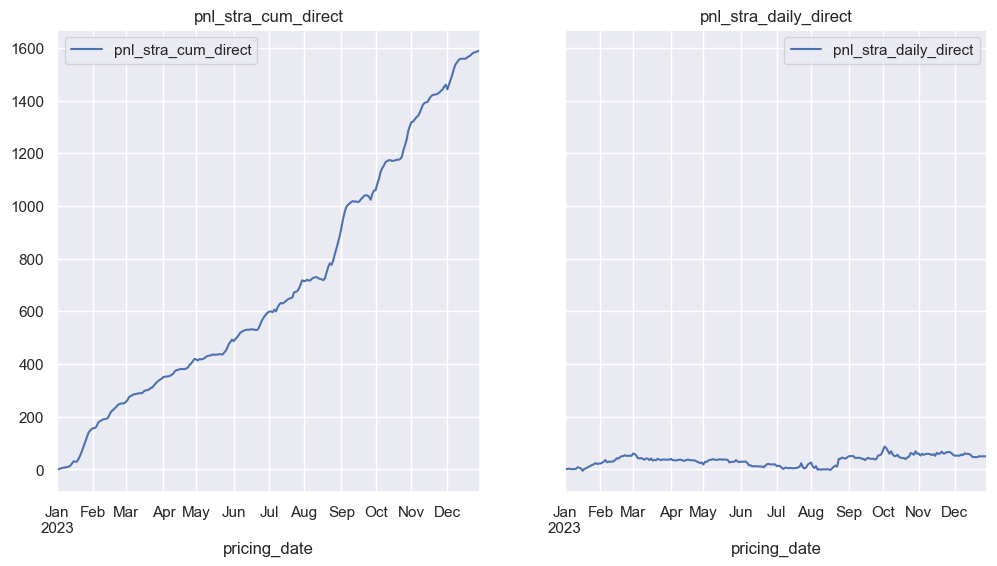

In [44]:
results = get_predictions(data.copy(), 'experiments', '2023-01-01', '2024-01-01', use_features=False, n_estimators=100, target_features=None)


# corrected pipeline

Use target features: False [None]
Use feature engineering for column selection: False [type=total_gain >= 30]
Model is stored in: experiments/models/model-partial-cols=84_use_fe=False_feat-import=total_gain_targ_fe=False.model
Number of columns: 84
Columns: Index(['ALVARI', 'ARAMCOSG', 'ARAMCOTF', 'ARCENERGY', 'BBEN', 'BPSG',
       'BRIGHTOILSG', 'BUYER1', 'BUYER2', 'CAOSG', 'CARGILLSG', 'CCMA',
       'CHEVRONSG', 'COASTAL', 'ENEOSSG', 'ENOC', 'FREEPTSG', 'GLENCORESG',
       'GPGLOBALSG', 'GULFSG', 'GUNVORSG', 'HL', 'IDEMITSU', 'ITGRES',
       'KAIROS', 'KOCHRI', 'LUKOIL', 'MACQUARIESG', 'MAERSKSG',
       'MERCURIARESOURCES', 'MERCURIASG', 'METS', 'MIPCO', 'P66SG', 'PETCO',
       'PETROCHINA', 'PETROSUMMIT', 'PTT', 'REPSOLSG', 'REXCOMM', 'RGES',
       'SELLER1', 'SIETCO', 'SINOHKPET', 'SINOPECFO', 'SINOPECHKSG', 'SKEISG',
       'SOCAR', 'SUMMITENERGY', 'TOTALSG', 'TRAFI', 'UNIPECSG', 'VITOLSG',
       'WANXIANG', 'ZENROCK', '_rgp_01_sz_3', '_rgp_02_sz_3', '_rgp_03_sz_3',
      

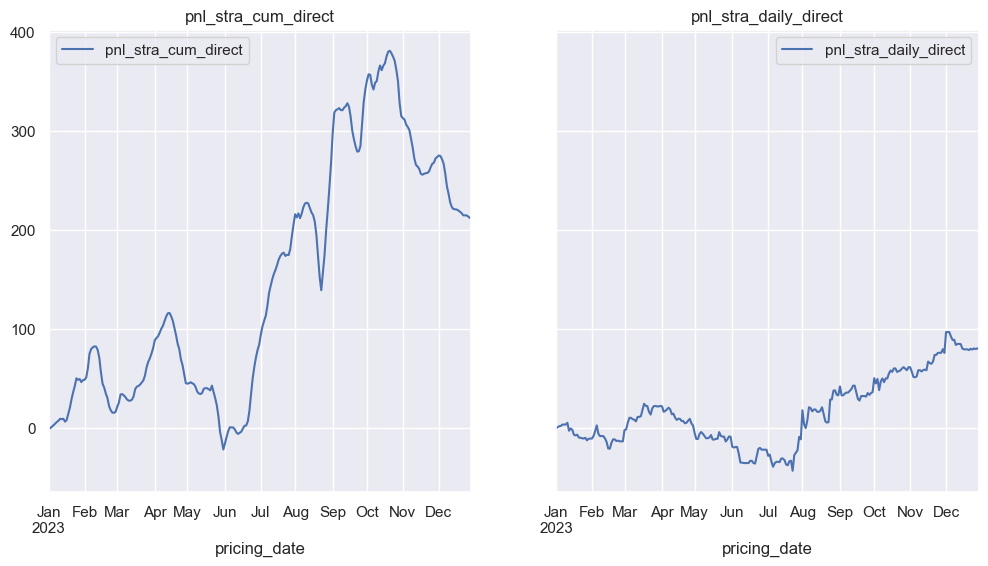

In [64]:
results = get_predictions(data.copy(), 'experiments', '2023-01-01', '2024-01-01', use_features=False, n_estimators=100, target_features=None)


In [39]:
import random

vals = list(data.iloc[-1, -10:].values)

for idx in range(10):
    vals.insert(0, random.randint(1, 143422))
    vals.pop()
    print(vals, end='\n====\n')

[107147, 3.45, 3.15, 2.95, 3.225, 3.5, 2.85, 2.75, 2.75, 2.75]
====
[108498, 107147, 3.45, 3.15, 2.95, 3.225, 3.5, 2.85, 2.75, 2.75]
====
[75713, 108498, 107147, 3.45, 3.15, 2.95, 3.225, 3.5, 2.85, 2.75]
====
[123741, 75713, 108498, 107147, 3.45, 3.15, 2.95, 3.225, 3.5, 2.85]
====
[133834, 123741, 75713, 108498, 107147, 3.45, 3.15, 2.95, 3.225, 3.5]
====
[17188, 133834, 123741, 75713, 108498, 107147, 3.45, 3.15, 2.95, 3.225]
====
[60072, 17188, 133834, 123741, 75713, 108498, 107147, 3.45, 3.15, 2.95]
====
[94854, 60072, 17188, 133834, 123741, 75713, 108498, 107147, 3.45, 3.15]
====
[84085, 94854, 60072, 17188, 133834, 123741, 75713, 108498, 107147, 3.45]
====
[76544, 84085, 94854, 60072, 17188, 133834, 123741, 75713, 108498, 107147]
====


In [ ]:
model, train, test, scaler, target_feature, model_name = train_model()